In [1]:
# Special directive to Jupiter Notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.register_matplotlib_converters()

##Import any other packages you may need here
from itertools import chain
from random import sample 
import scipy
# Read and show xray
from skimage.io import imread, imshow
from skimage import io

import pydicom
from itertools import chain

# Recommended to correct an error in the fig, ax
from ipykernel import kernelapp as app

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the some EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data by passing the path to the file

# Path of the file to read
filepath = '/data/Data_Entry_2017.csv'

# Read the file into a variable all_xray_df
all_xray_df = pd.read_csv(filepath)


all_xray_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
2731,00000724_000.png,Fibrosis,0,724,56,F,PA,2048,2500,0.171,0.171,NaN
5620,00001511_001.png,No Finding,1,1511,17,M,PA,2048,2500,0.171,0.171,NaN
1060,00000255_000.png,No Finding,0,255,52,F,PA,2048,2500,0.168,0.168,NaN


### Exploriatory Data Analysis
**1. Label distribution on the data**

In [4]:
## Here I'm just going to split up my "Finding Labels" column by the | symbol separator 
# so that I have one column per disease in my dataframe,
# with a binary flag. This makes EDA a lot easier! 

# maps/gets each row of the Finding label column and split it using the '|' character as separable. 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for label in all_labels:
    if len(label)>1: # leave out empty labels
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
        

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
# Distribution of diseases
# all_labels variable is a list of all these columns
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

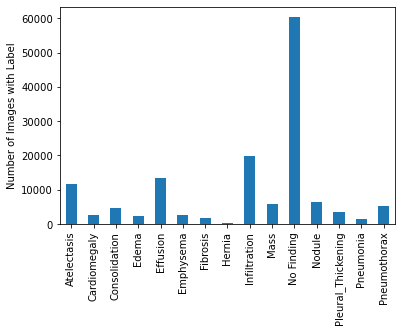

In [6]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

As expected pneumonia only constitute only 1% of the dataset. 50% of the data constitute no findings and the rest 40% are concurrent diseases. Of the 40% concurrent diseases, Infilteration, Effusion and Atectasis are the most common. Overall , negative finding with respect to pneumonia classes is 90% of the dataset.

### 1.1 Absolute count of each disease
That occured concurrently with pneumonia


In [7]:
# Pull the first disease
comorb1 = all_xray_df['Image Index'][0]
comorb1

'00000001_000.png'

In [8]:
#img = imread(comorb1)

In [9]:
# Absolute total count of each disease
diseases_freq ={}
all_labels = ['Atelectasis','Effusion','Pneumothorax','Infiltration','Cardiomegaly','Mass','Nodule']
for i in all_labels:
    # Use each disease as the key, then count each time I see the key with pnueumonia
    diseases_freq[i] = len(all_xray_df[all_xray_df.Pneumonia==1][all_xray_df[i]==1])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [10]:
diseases_freq

{'Atelectasis': 262,
 'Effusion': 269,
 'Pneumothorax': 41,
 'Infiltration': 605,
 'Cardiomegaly': 41,
 'Mass': 71,
 'Nodule': 70}

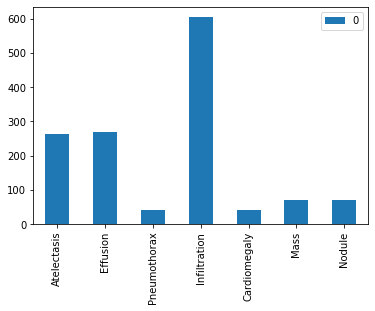

In [11]:
# Creating dataframe by converting dict to list of items
ds = pd.DataFrame.from_dict(diseases_freq, orient='index').plot(kind='bar')


### 1.2 Thirty most concurrent diseases with Pneumonia

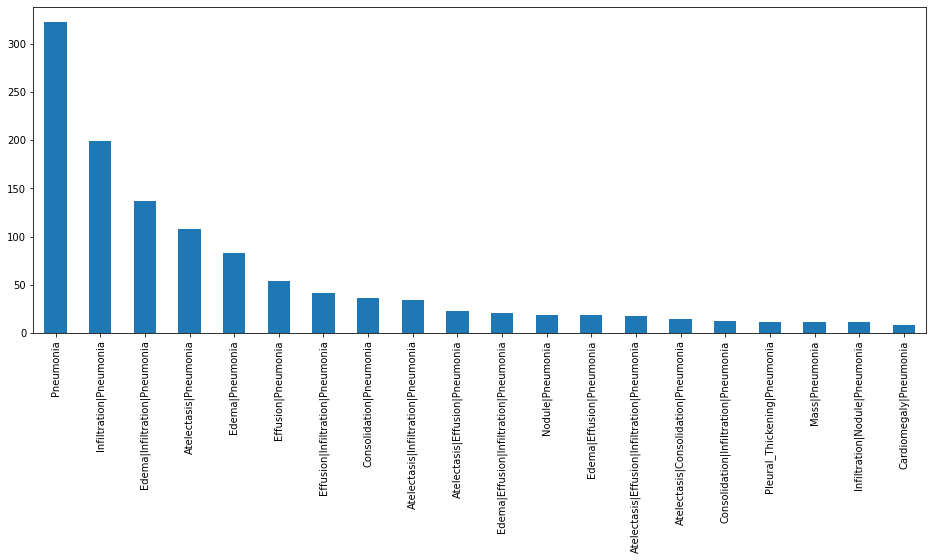

In [12]:
## Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
# First, set a condition(all_xray_df.pneumonia) for accessing the data object(all_xray_df) from Pandas, then that combined with age with plot
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')


The 30 most common concurrent disease with pneumonia are shown. Infilteration, Effusion and Atectasis being the most common concurrences.

### 2. Basic demographics

**2.1 Gender distribution**

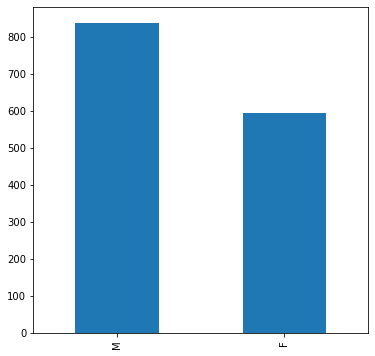

In [13]:
# Plot patient demographic data such as gender
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')

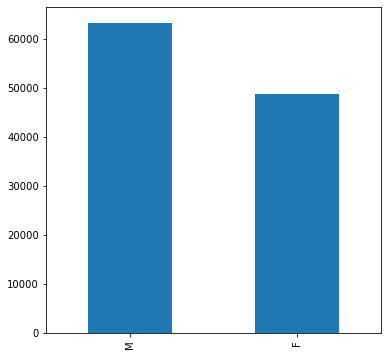

In [14]:
# Plot patient demographic data such as gender
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

The number males in the test were marginally more than that of females by ratio 3:2. This ration remain consistent in the overal dataset and the pneumonia cohort

**2.2 Patient Age**

Text(0.5, 1.0, 'Ages group trained on')

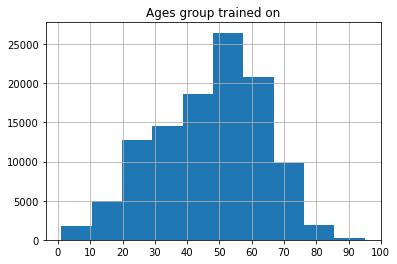

In [15]:
# Patient demographic data- my algorithm was trained on
#plt.figure(figsize=(10,6))
# First, set a condition(all_xray_df['Patient Age'] <100 for accessing the data object(all_xray_df) from Pandas, then that combined with age with plot 
all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'].hist(bins=10)
plt.xticks(list(range(0,101,10)))
plt.title('Ages group trained on')


The device was trained on people of age below 80 years.

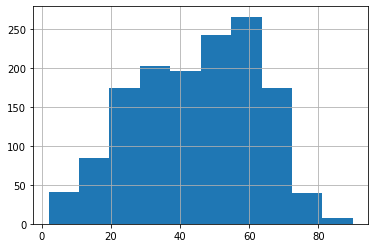

In [16]:
all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'][all_xray_df.Pneumonia ==1].hist(bins=10)

**2.4 Age distribution for Pneumonia cases only**

This graph show that 50- 60 years age group most affected by pneumonia

**2.3 View Position of chest x ray with Pneumonia**

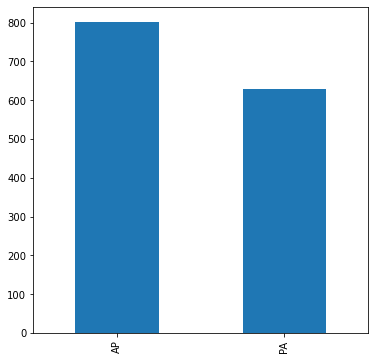

In [17]:
# Patient Position distribution of Pneumonia
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['View Position'].value_counts().plot(kind='bar')


There were more chest x-ray AP than PA views with people who have pneumonia

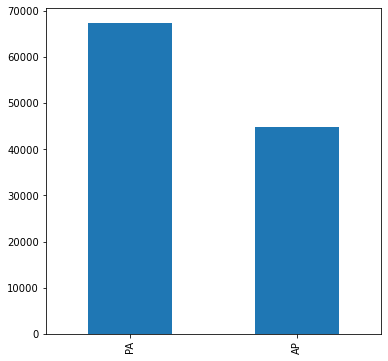

In [18]:
#  Patient position distribution of the dataset
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')


PA chest X-rays are are common than than AP views in this dataset.

### Number of concurrent disease with pneumonia

In [19]:
comorb = pd.read_csv('comorbidity.csv')

In [20]:
comorb.head()

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,ground_truth,comorbidity
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,1.0
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,1.0
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,2.0
3,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,0.0
4,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,0.0


In [21]:
# Create data I will use for my plot
comorb[comorb.Pneumonia==1]['comorbidity'].value_counts()

1.0    651
0.0    465
2.0    249
3.0     56
4.0      8
5.0      2
Name: comorbidity, dtype: int64

In [22]:
# Sort them into order and get the values
comorb_count= comorb[comorb.Pneumonia==1]['comorbidity'].value_counts().sort_index()
y =comorb_count.values
y

array([465, 651, 249,  56,   8,   2])

In [23]:
# Call index values here
x = comorb_count.index
x

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype='float64')

In [24]:
# Sort the index Index for x axis

comorb[comorb.Pneumonia==1]['comorbidity'].value_counts().sort_index().index


Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype='float64')

Text(0, 0.5, 'num_of_patients')

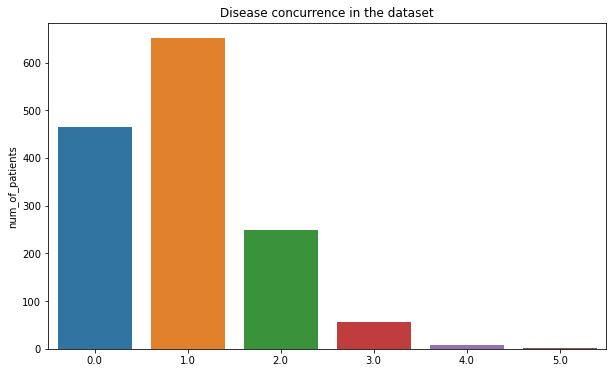

In [25]:
# Set the width and height of the figure
plt.figure(figsize=(10, 6))

# Add title
plt.title('Disease concurrence in the dataset')

# The comorbidity column is used to indentify the x axis and index for the y axis
sns.barplot(x=comorb_count.index, y=comorb_count.values)


plt.ylabel('num_of_patients')


50% of the patients had no concurrent disease. 

### Pixel-level data Analysis

In [26]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2284,00011700_001.png,Fibrosis,1,11700,061Y,F,PA,2544,3056,0.139,0.139
2373,00012021_000.png,No Finding,0,12021,024Y,M,AP,2500,2048,0.168,0.168
3108,00015351_001.png,No Finding,1,15351,039Y,M,AP,2500,2048,0.168,0.168


In [27]:
# Create paths to images and assign it to the variable paths

# x represent image index
paths = {os.path.basename(x): x for x in glob(os.path.join('/data/','images*/','images/', '*.png'))}

# Create a column path and populate it by mapping panda series index to thier image path
sample_df['path'] = sample_df['Image Index'].map(paths.get)
# Random sample of 3 images
sample_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
641,00003306_000.png,No Finding,0,3306,050Y,F,PA,2048,2500,0.171,0.171,/data/images_002/images/00003306_000.png
3358,00016579_000.png,Effusion|Nodule,0,16579,065Y,F,PA,2992,2991,0.143,0.143,/data/images_008/images/00016579_000.png
4724,00024300_000.png,No Finding,0,24300,031Y,F,PA,2488,2673,0.143,0.143,/data/images_010/images/00024300_000.png


### 1. Assess disease pixel intensity
The focus is on the pixel intensity of pneumonia and the most frequent disease concurrences of pneumonia

### A list of labels from samples.csv

### Plots of image and intensity values
**For a single row of image and  intensity values**

Lets start with you want to select images which has diagnosed with Pneumonia
```
num_rows =3
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[1].hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
```

The first argument is number of rows, the second argument is the number of columns. If you only have 1 row, ax is a 1-D array:
    
**For a multiple rows of image and  intensity values**

If you have many rows and you want to loop over them, ax will be a 2-D array:
```
fig, ax = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))
ax[i][0].imshow(img, cmap='gray')
ax[i][1].hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
```

**Suptitle method**

If you need an intermediate title for each row, I'd recommend you making a new figure for each row, because in case of 2-D ax, you can't set the row title.

To set the row title, use suptitle method on figure, and to set a subplot title, use set_title method.

To make the suptitle distinguishable, adjust subplots by top parameter:

```
 for i in range(num_rows):
            fig, ax = plt.subplots(1, 2, figsize= (15,5))
            # To make the suptitle distinguishable, adjust subplots by top parameter:
            fig.subplots_adjust(top=0.8)
            fig.suptitle('Title {0}'.format(d), fontsize=14)
            ax[0].imshow(img, cmap='gray')
            ax[0].set_title('Image {0}'.format(data[d][0]))
            ax[1].hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
            ax[1].set_title('Histogram {0}'.format(data[d][0]))
            
            
```




In [28]:
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### Pneumonia image and intensty plots

In [99]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Pneumonia'].sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,0.143,/data/images_007/images/00014201_008.png
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,0.143,/data/images_006/images/00012733_000.png
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,0.143,/data/images_006/images/00012667_000.png


In [100]:
p = sample_df[sample_df['Image Index'] == '00014201_008.png']
p


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,0.143,/data/images_007/images/00014201_008.png


Since I have the image index I will do image and pixel analysis.

<function matplotlib.pyplot.show(*args, **kw)>

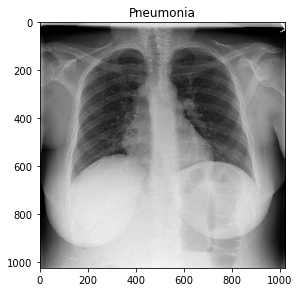

In [102]:
img =io.imread('/data/images_007/images/00014201_008.png')
imgplot = imshow(img)
img_title = plt.title('Pneumonia')
plt.show


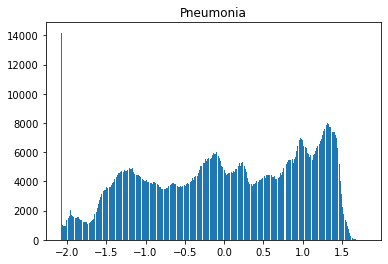

In [103]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Pneumonia')
plt.show()

### Infiltration image and intensty plots

In [104]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Infiltration'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3963,00019576_024.png,Infiltration,24,19576,049Y,M,AP,2048,2500,0.168,0.168,/data/images_009/images/00019576_024.png
5069,00026928_001.png,Infiltration,1,26928,069Y,F,PA,2992,2991,0.143,0.143,/data/images_011/images/00026928_001.png
5278,00028402_000.png,Infiltration,0,28402,030Y,M,PA,2544,3056,0.139,0.139,/data/images_012/images/00028402_000.png


In [105]:
inf = sample_df[sample_df['Image Index'] == '00019576_024.png']
inf

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3963,00019576_024.png,Infiltration,24,19576,049Y,M,AP,2048,2500,0.168,0.168,/data/images_009/images/00019576_024.png


<function matplotlib.pyplot.show(*args, **kw)>

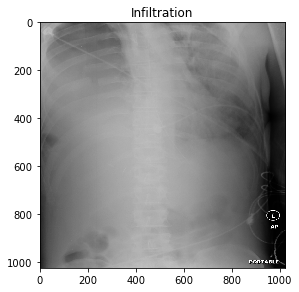

In [106]:
img = io.imread('/data/images_009/images/00019576_024.png')
imgplot = imshow(img)
img_title = plt.title('Infiltration')
plt.show


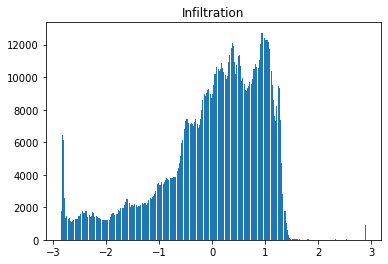

In [107]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Infiltration')
plt.show()

In [120]:
inf1 = sample_df[sample_df['Image Index'] == '00028402_000.png']
inf1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
5278,00028402_000.png,Infiltration,0,28402,030Y,M,PA,2544,3056,0.139,0.139,/data/images_012/images/00028402_000.png


<function matplotlib.pyplot.show(*args, **kw)>

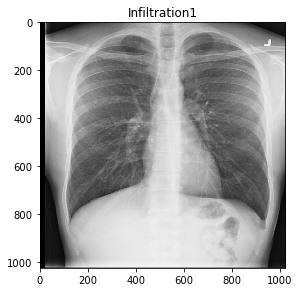

In [122]:
img = io.imread('/data/images_012/images/00028402_000.png')
imgplot = imshow(img)
img_title = plt.title('Infiltration1')
plt.show



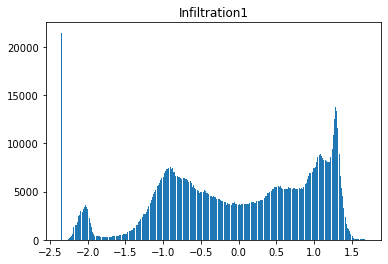

In [123]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Infiltration1')
plt.show()

### Atelectasis image and intensty plots

In [35]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Atelectasis'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4963,00026139_002.png,Atelectasis,2,26139,072Y,M,PA,2992,2991,0.143,0.143,/data/images_011/images/00026139_002.png
3796,00018642_005.png,Atelectasis,5,18642,057Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00018642_005.png
2699,00013615_019.png,Atelectasis,19,13615,010Y,F,AP,2500,2048,0.168,0.168,/data/images_006/images/00013615_019.png


In [36]:
a = sample_df[sample_df['Image Index'] == '00020966_000.png']
a


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4252,00020966_000.png,Atelectasis,0,20966,052Y,M,PA,2930,2961,0.143,0.143,/data/images_010/images/00020966_000.png


<function matplotlib.pyplot.show(*args, **kw)>

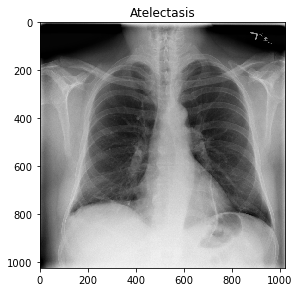

In [108]:
img = io.imread('/data/images_010/images/00020966_000.png')
imgplot = imshow(img)
img_title = plt.title('Atelectasis')
plt.show


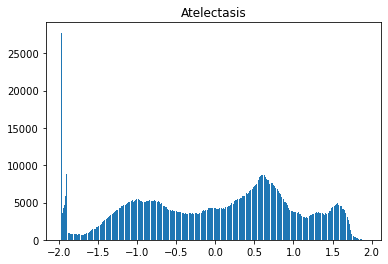

In [109]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Atelectasis')
plt.show()

### Cardiomegaly image and intensty plots

In [38]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Cardiomegaly'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1520,00007945_000.png,Cardiomegaly,0,7945,035Y,F,PA,2048,2500,0.168,0.168,/data/images_004/images/00007945_000.png
909,00004822_007.png,Cardiomegaly,7,4822,034Y,M,PA,3056,2544,0.139,0.139,/data/images_003/images/00004822_007.png
226,00001249_010.png,Cardiomegaly,10,1249,041Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00001249_010.png


In [39]:
c = sample_df[sample_df['Image Index'] == '00006875_008.png']
c

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1309,00006875_008.png,Cardiomegaly,8,6875,064Y,F,AP,3056,2544,0.139,0.139,/data/images_004/images/00006875_008.png


<function matplotlib.pyplot.show(*args, **kw)>

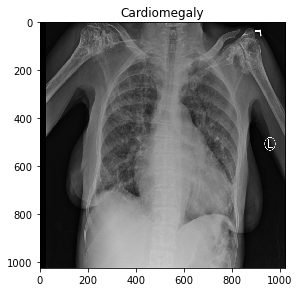

In [110]:
img = io.imread('/data/images_004/images/00006875_008.png')
imgplot = imshow(img)
img_title = plt.title('Cardiomegaly')
plt.show


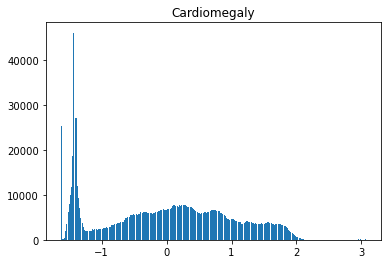

In [111]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Cardiomegaly')
plt.show()

### Consolidation image and intensty plots

In [41]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Consolidation'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3208,00015770_035.png,Consolidation,35,15770,066Y,F,AP,2500,2048,0.168,0.168,/data/images_007/images/00015770_035.png
2701,00013615_042.png,Consolidation,42,13615,010Y,F,AP,2500,2048,0.168,0.168,/data/images_006/images/00013615_042.png
4617,00023085_006.png,Consolidation,6,23085,069Y,F,PA,2544,3056,0.139,0.139,/data/images_010/images/00023085_006.png


In [42]:
co = sample_df[sample_df['Image Index'] == '00013670_135.png']
co

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2731,00013670_135.png,Consolidation,135,13670,056Y,M,AP,2500,2048,0.168,0.168,/data/images_006/images/00013670_135.png


<function matplotlib.pyplot.show(*args, **kw)>

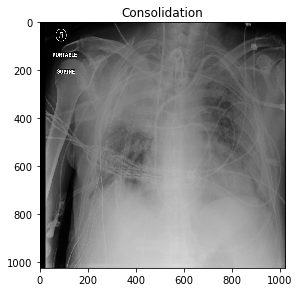

In [112]:
img = io.imread('/data/images_006/images/00013670_135.png')
imgplot = imshow(img)
img_title = plt.title('Consolidation')
plt.show

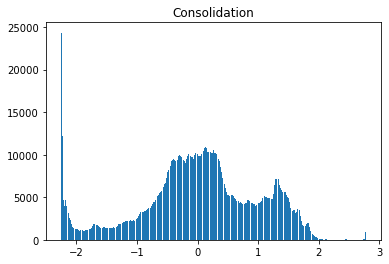

In [113]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Consolidation')
plt.show()

### Edema image and intensty plots

In [44]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Edema'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4804,00025252_048.png,Edema,48,25252,030Y,M,AP,3056,2544,0.139,0.139,/data/images_011/images/00025252_048.png
882,00004659_000.png,Edema,0,4659,035Y,F,AP,2500,2048,0.171,0.171,/data/images_003/images/00004659_000.png
2621,00013176_005.png,Edema,5,13176,055Y,F,AP,2500,2048,0.168,0.168,/data/images_006/images/00013176_005.png


In [45]:
e = sample_df[sample_df['Image Index'] == '00015799_007.png']
e

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3211,00015799_007.png,Edema,7,15799,068Y,F,AP,2500,2048,0.168,0.168,/data/images_007/images/00015799_007.png


<function matplotlib.pyplot.show(*args, **kw)>

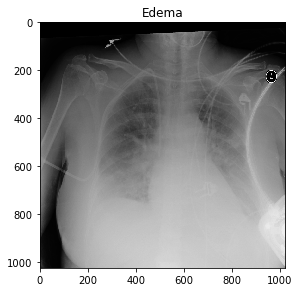

In [114]:
img = io.imread('/data/images_007/images/00015799_007.png')
imgplot = imshow(img)
img_title = plt.title('Edema')
plt.show


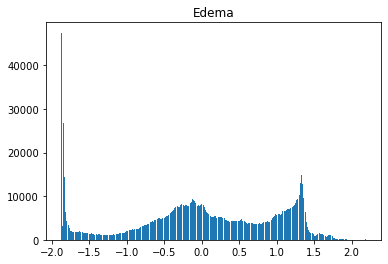

In [115]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Edema')
plt.show()

### Effusion image and intensty plots

In [47]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Effusion'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
310,00001650_011.png,Effusion,11,1650,063Y,M,PA,2992,2991,0.143,0.143,/data/images_002/images/00001650_011.png
4245,00020918_000.png,Effusion,0,20918,070Y,M,PA,3056,2544,0.139,0.139,/data/images_009/images/00020918_000.png
2694,00013608_011.png,Effusion,11,13608,016Y,M,PA,2774,2449,0.143,0.143,/data/images_006/images/00013608_011.png


In [48]:
e = sample_df[sample_df['Image Index'] == '00018555_003.png']
e

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3779,00018555_003.png,Effusion,3,18555,015Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00018555_003.png


<function matplotlib.pyplot.show(*args, **kw)>

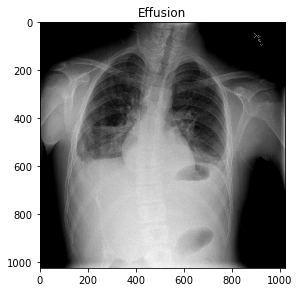

In [116]:
img = io.imread('/data/images_009/images/00018555_003.png')
imgplot = imshow(img)
img_title = plt.title('Effusion')
plt.show

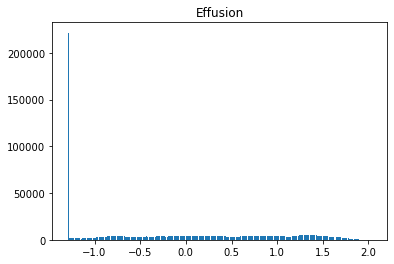

In [117]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Effusion')
plt.show()

### Fibrosis image and intensty plots

In [50]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Effusion'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1594,00008295_012.png,Effusion,12,8295,066Y,M,PA,2021,2021,0.194311,0.194311,/data/images_004/images/00008295_012.png
4024,00019829_000.png,Effusion,0,19829,071Y,M,PA,2992,2991,0.143000,0.143000,/data/images_009/images/00019829_000.png
2743,00013736_000.png,Effusion,0,13736,067Y,M,PA,2992,2991,0.143000,0.143000,/data/images_006/images/00013736_000.png


In [51]:
f = sample_df[sample_df['Image Index']=='00009992_002.png']
f

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1904,00009992_002.png,Effusion,2,9992,037Y,F,PA,2048,2500,0.168,0.168,/data/images_005/images/00009992_002.png


<function matplotlib.pyplot.show(*args, **kw)>

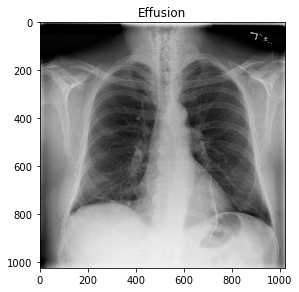

In [118]:
img = io.imread('/data/images_010/images/00020966_000.png')
imgplot = imshow(img)
img_title = plt.title('Effusion')
plt.show



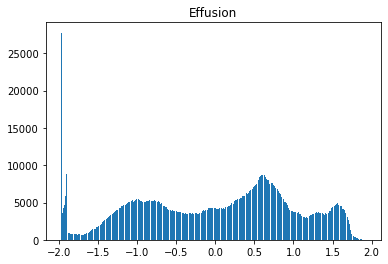

In [119]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Effusion')
plt.show()

### Hernia image and intensty plots

In [53]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Hernia'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1662,00008694_002.png,Hernia,2,8694,054Y,F,AP,2500,2048,0.168,0.168,/data/images_004/images/00008694_002.png
1418,00007352_000.png,Hernia,0,7352,056Y,M,PA,2500,2048,0.168,0.168,/data/images_004/images/00007352_000.png
1546,00008015_000.png,Hernia,0,8015,062Y,M,PA,2500,2048,0.168,0.168,/data/images_004/images/00008015_000.png


In [65]:
h = sample_df[sample_df['Image Index']=='00008694_002.png']
h


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1662,00008694_002.png,Hernia,2,8694,054Y,F,AP,2500,2048,0.168,0.168,/data/images_004/images/00008694_002.png


<function matplotlib.pyplot.show(*args, **kw)>

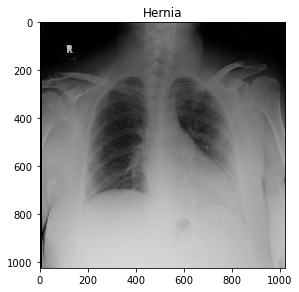

In [68]:
img = io.imread('/data/images_004/images/00008694_002.png')
imgplot = imshow(img)
img_title = plt.title('Hernia')
plt.show


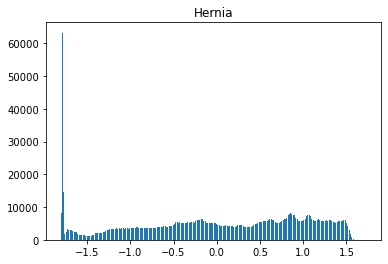

In [69]:

# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Hernia')
plt.show()

### Mass image and intensty plots

In [81]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Mass'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2469,00012413_007.png,Mass,7,12413,043Y,F,AP,2500,2048,0.168,0.168,/data/images_006/images/00012413_007.png
3325,00016429_008.png,Mass,8,16429,047Y,F,PA,2674,2991,0.143,0.143,/data/images_008/images/00016429_008.png
11,00000079_000.png,Mass,0,79,063Y,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000079_000.png


In [82]:
m = sample_df[sample_df['Image Index']=='00011199_000.png']
m


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2174,00011199_000.png,Mass,0,11199,034Y,F,PA,2686,2797,0.143,0.143,/data/images_005/images/00011199_000.png


<function matplotlib.pyplot.show(*args, **kw)>

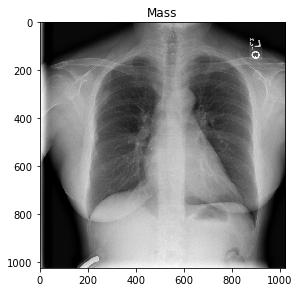

In [83]:
img = io.imread('/data/images_005/images/00011199_000.png')
imgplot = imshow(img)
img_title = plt.title('Mass')
plt.show



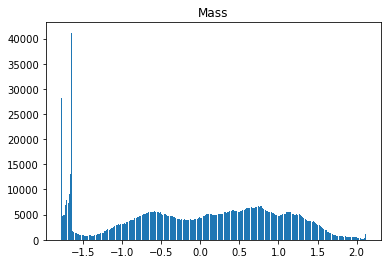

In [84]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Mass')
plt.show()

### Nodule image and intensty plots

In [87]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Nodule'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
5130,00027300_000.png,Nodule,0,27300,061Y,M,PA,2992,2991,0.143,0.143,/data/images_011/images/00027300_000.png
3158,00015555_000.png,Nodule,0,15555,043Y,M,PA,2992,2991,0.143,0.143,/data/images_007/images/00015555_000.png
2771,00013888_000.png,Nodule,0,13888,058Y,F,PA,2990,2807,0.143,0.143,/data/images_007/images/00013888_000.png


In [88]:
n = sample_df[sample_df['Image Index']=='00028271_003.png']
n

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
5264,00028271_003.png,Nodule,3,28271,056Y,F,PA,2250,2991,0.143,0.143,/data/images_012/images/00028271_003.png


<function matplotlib.pyplot.show(*args, **kw)>

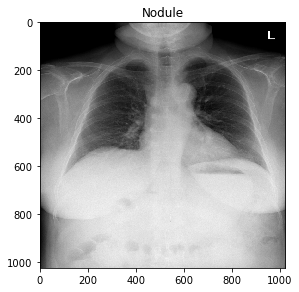

In [89]:
img = io.imread('/data/images_012/images/00028271_003.png')
imgplot = imshow(img)
img_title = plt.title('Nodule')
plt.show



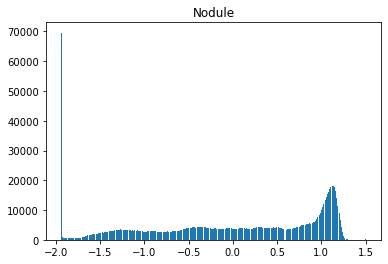

In [90]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Nodule')
plt.show()

### Pleural_Thickening image and intensty plots

In [91]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Pleural_Thickening'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3941,00019437_007.png,Pleural_Thickening,7,19437,059Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00019437_007.png
4377,00021610_016.png,Pleural_Thickening,16,21610,045Y,M,PA,2778,2557,0.143,0.143,/data/images_010/images/00021610_016.png
2551,00012834_105.png,Pleural_Thickening,105,12834,033Y,M,AP,2500,2048,0.168,0.168,/data/images_006/images/00012834_105.png


In [92]:
pt = sample_df[sample_df['Image Index']=='00019437_007.png']
pt

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3941,00019437_007.png,Pleural_Thickening,7,19437,059Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00019437_007.png


<function matplotlib.pyplot.show(*args, **kw)>

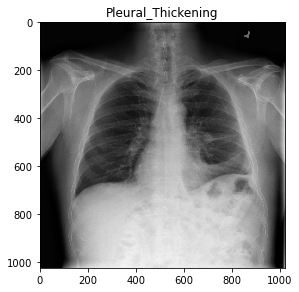

In [93]:
img = io.imread('/data/images_009/images/00019437_007.png')
imgplot = imshow(img)
img_title = plt.title('Pleural_Thickening')
plt.show


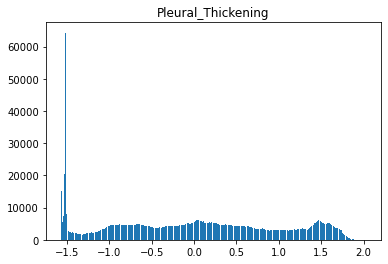

In [94]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Pleural_Thickening')
plt.show()

### Pneumothorax image and intensty plots

In [95]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Pneumothorax'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
440,00002355_002.png,Pneumothorax,2,2355,068Y,F,PA,2670,2991,0.143,0.143,/data/images_002/images/00002355_002.png
4545,00022726_009.png,Pneumothorax,9,22726,045Y,F,PA,2992,2991,0.143,0.143,/data/images_010/images/00022726_009.png
703,00003659_013.png,Pneumothorax,13,3659,054Y,F,PA,2992,2991,0.143,0.143,/data/images_002/images/00003659_013.png


In [96]:
ptx = sample_df[sample_df['Image Index']=='00002355_002.png']
ptx


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
440,00002355_002.png,Pneumothorax,2,2355,068Y,F,PA,2670,2991,0.143,0.143,/data/images_002/images/00002355_002.png


<function matplotlib.pyplot.show(*args, **kw)>

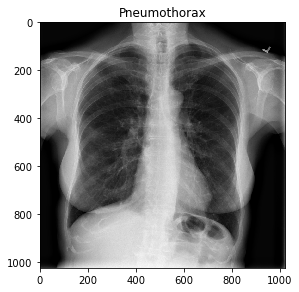

In [97]:
img = io.imread('/data/images_002/images/00002355_002.png')
imgplot = imshow(img)
img_title = plt.title('Pneumothorax')
plt.show


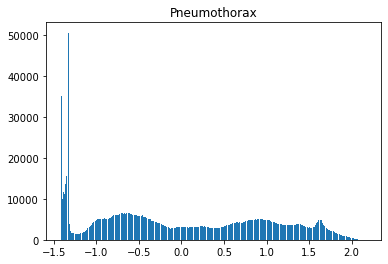

In [98]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Pneumothorax')
plt.show()

In [60]:
###  image and intensty plots

### Intensity values
To quickly visualize patterns

Infilteration stands out with a diffuse pattern of intensity, A similar pattern is observed in effusion. These patterns do not match the observed pattern in pneumonia which is less intense. 
For a mass, there appear to be not only a tiny focus of very high intensity in the middle, but the intensity has a uniform color, the kind not seen in any other disease